In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
dask.config.set({"dataframe.convert-string": False})


dask.config.set({"distributed.comm.retry.count": 10})
dask.config.set({"distributed.comm.timeouts.connect": 30})
dask.config.set({'distributed.nanny.pre-spawn-environ.MALLOC_TRIM_THRESHOLD_': 1_000})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [2]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from evaluate import evaluate_updated
from gpmcmc import model_gp
from evaluate import half_eval as half_eval

In [3]:
import tape as tape_v

In [4]:
tape_v.__version__

'0.3.5'

In [5]:
%%time
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource")
# change to ztf_zource

CPU times: user 46.5 s, sys: 17.5 s, total: 1min 3s
Wall time: 1min 3s


In [6]:
%%time
# Load FGK objects...
fgk_object = dask.dataframe.read_parquet("/nvme/users/atzanida/tmp/starhorse_new_april21.parquet").compute()

CPU times: user 58.3 s, sys: 7min 45s, total: 8min 43s
Wall time: 30.4 s


In [7]:
final_selected_fgk = fgk_object[['RA_ICRS_StarHorse', 'DE_ICRS_StarHorse', 'ps1_objid_ztf_dr14', 
                                 'teff50_StarHorse', 'GMAG0_StarHorse']]

In [8]:
slab_1 = final_selected_fgk.query("DE_ICRS_StarHorse > -5 and DE_ICRS_StarHorse < 5")

In [9]:
len(slab_1)

6416731

In [10]:
from distributed import Client
client = Client(n_workers=50, 
                threads_per_worker=1, 
                memory_limit='80GB')

In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 50
Total threads: 50,Total memory: 3.64 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34524,Workers: 50
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: 3 minutes ago,Total memory: 3.64 TiB
Comm: tcp://127.0.0.1:41452,Total threads: 1
Dashboard: http://127.0.0.1:41886/status,Memory: 74.51 GiB
Nanny: tcp://127.0.0.1:42621,


In [13]:
%%time
hips_fgk = lsdb.from_dataframe(slab_1,
                                ra_column="RA_ICRS_StarHorse", 
                                dec_column="DE_ICRS_StarHorse", threshold=1_000_000)

CPU times: user 54min 19s, sys: 11min 50s, total: 1h 6min 10s
Wall time: 43min 2s


In [14]:
hips_fgk

,RA_ICRS_StarHorse,DE_ICRS_StarHorse,ps1_objid_ztf_dr14,teff50_StarHorse,GMAG0_StarHorse,Norder,Dir,Npix
npartitions=24,,,,,,,,
0,float64,float64,int64,float64,float64,uint8,uint64,uint64
1152921504606846976,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
12682136550675316736,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [15]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper
#pd.options.mode.chained_assignment = None

# Initialize an Ensemble
ens = Ensemble(client=client)

In [16]:
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 50
Total threads: 50,Total memory: 3.64 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34524,Workers: 50
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: 55 minutes ago,Total memory: 3.64 TiB
Comm: tcp://127.0.0.1:41452,Total threads: 1
Dashboard: http://127.0.0.1:41886/status,Memory: 74.51 GiB
Nanny: tcp://127.0.0.1:42621,


In [17]:
#%%time
#fgk_object = lsdb.read_hipscat("/nvme/users/atzanida/tmp/sample_final_starhorse_hips")

In [18]:
%%time
_sources = hips_fgk.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 14.9 s, sys: 907 ms, total: 15.8 s
Wall time: 15.2 s


In [19]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=hips_fgk._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

In [20]:
# feature evaluation 
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma', # in deviation
    'Ndips',
    'rate',
    'chi2dof',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',    
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'lc_score']

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [21]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate_updated,
    'mjd_ztf_zource', 'mag_ztf_zource', 
    'magerr_ztf_zource', 'catflags_ztf_zource',
    'band_ztf_zource',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 103 ms, sys: 14.3 ms, total: 117 ms
Wall time: 114 ms


In [22]:
%%time
ens.object.join(calc_).update_ensemble()

CPU times: user 2.77 s, sys: 207 ms, total: 2.98 s
Wall time: 2.94 s


In [23]:
#%%time
# check if ens.head returns something intuitive...
#demo_table = ens.object.head(50_000, npartitions=250)

In [ ]:
%%time
ens.object.to_parquet("/epyc/ssd/users/atzanida/tmp/starH24/StarHorse_Full_Comp_V_99_April24.parquet",
                      engine='pyarrow')

2024-04-24 13:38:08,250 - distributed.worker - ERROR - Unexpected exception during heartbeat. Closing worker.
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils_comm.py", line 424, in retry
    return await coro()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/core.py", line 1392, in send_recv_from_rpc
    comm = await self.pool.connect(self.addr)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/core.py", line 1591, in connect
    raise RuntimeError("Connecti

2024-04-24 14:22:24,425 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-24 14:22:52,708 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-24 14:23:08,440 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-24 14:23:57,178 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-24 14:24:37,803 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-04-24 14:25:14,383 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2024-04-24 14:25:16,443 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2024-04-24 14:25:46,076 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 14:49:11,126 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-24 14:49:48,282 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-24 14:49:51,605 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 14:49:54,096 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-24 14:49:56,845 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-24 14:50:01,050 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-24 14:51:14,245 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-24 14:51:37,819 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 15:11:53,570 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-24 15:12:13,740 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-04-24 15:12:20,875 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-24 15:12:48,064 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-24 15:14:02,549 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-04-24 15:14:07,394 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-24 15:14:26,267 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-24 15:16:27,306 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 15:39:44,105 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-24 15:40:11,086 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-24 15:40:15,360 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-04-24 15:40:19,916 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-24 15:40:48,795 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-24 15:40:55,267 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-24 15:41:28,008 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-24 15:41:35,841 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 16:08:08,361 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-24 16:08:34,814 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-04-24 16:08:36,167 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-24 16:08:48,739 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 16:09:14,192 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 16:10:24,720 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-24 16:10:27,552 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-24 16:12:09,529 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 16:42:57,105 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-24 16:43:05,847 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-04-24 16:43:47,962 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 16:44:14,604 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-24 16:44:29,551 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 16:44:54,614 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-24 16:47:45,350 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 16:49:17,819 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 17:05:11,020 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 17:05:42,389 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 17:06:08,258 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-24 17:07:52,158 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 17:08:01,682 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 17:09:09,558 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 17:09:16,205 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-24 17:09:27,535 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 17:54:11,835 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 17:56:03,962 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 17:57:06,990 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-24 17:57:39,130 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-24 17:58:03,218 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 17:58:35,157 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-24 17:58:41,847 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-24 17:59:06,910 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 18:47:18,429 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-24 18:47:44,558 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 18:47:54,606 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 18:48:45,612 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 18:48:55,116 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-24 18:50:22,578 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 18:50:34,060 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-24 18:50:50,428 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-24 19:09:44,681 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39365
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2863, in get_data_from_worker
   

In [2]:
print (True)

True


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
tab = pd.read_parquet("/epyc/ssd/users/atzanida/tmp/starH24/StarHorse_Full_Comp_v3.parquet")

In [15]:
len(tab)

1113659

In [16]:
scr = tab[tab['lc_score']>0]

Text(0, 0.5, 'Score')

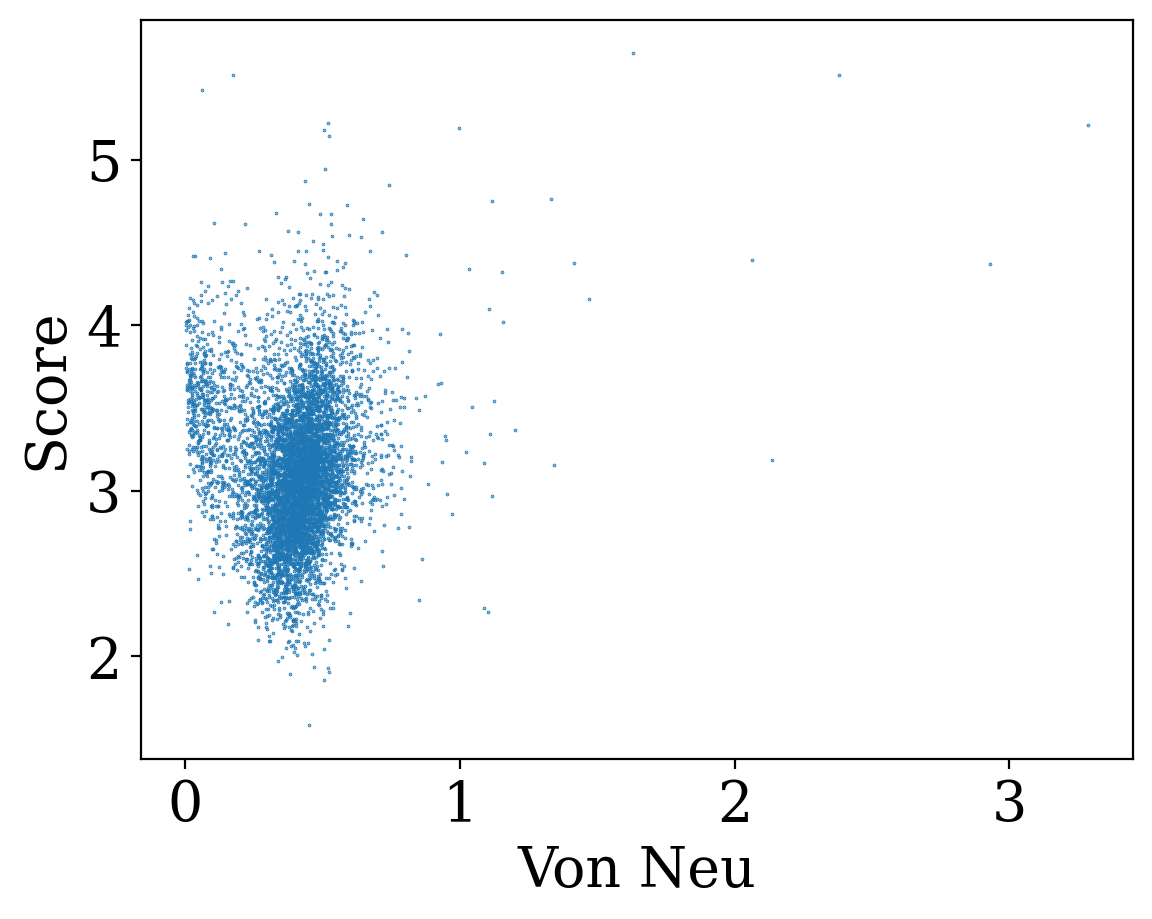

In [23]:
plt.scatter(scr['invNeumann'], np.log10(scr['lc_score']), s=0.1)
plt.xlabel("Von Neu")
plt.ylabel("Score")

In [17]:
len(scr[np.log10(scr['lc_score'])>4.5])

30

Text(0.5, 0, 'Score')

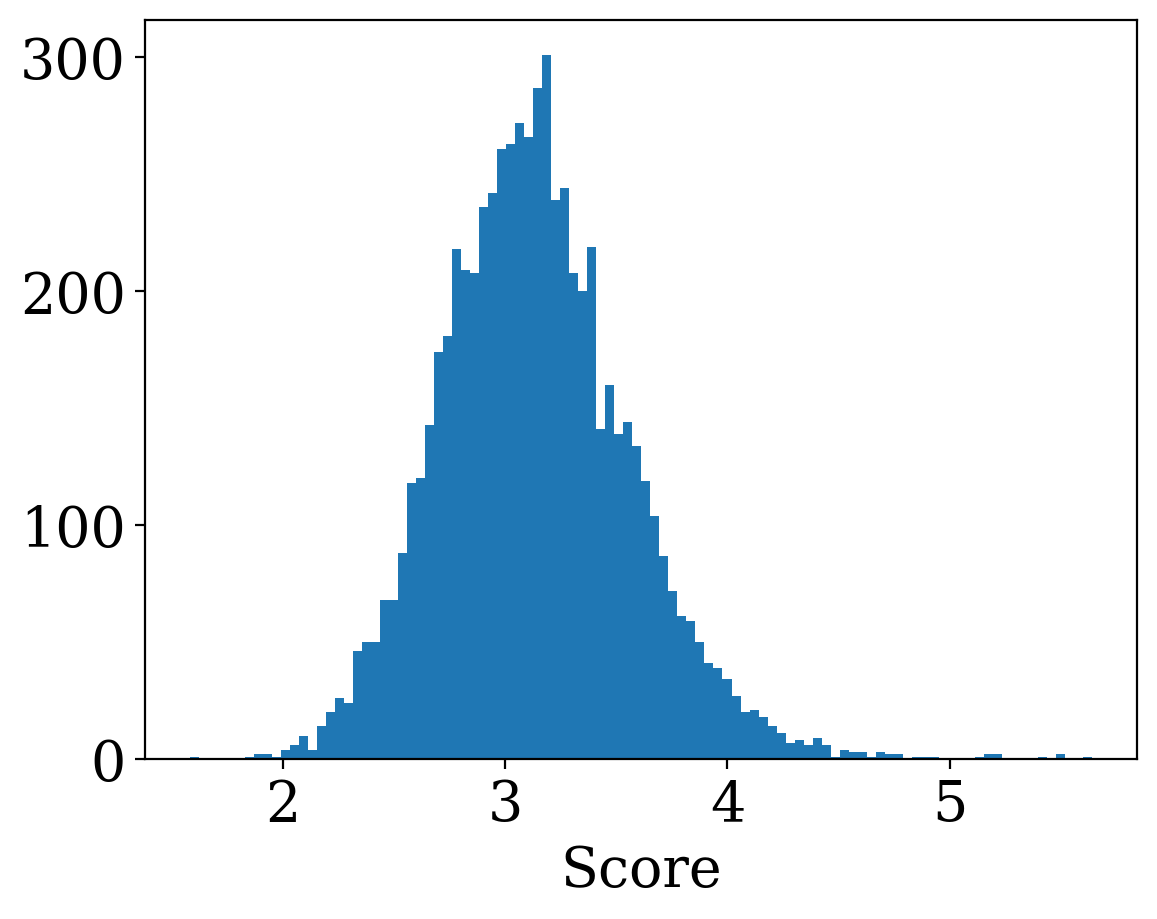

In [24]:
_ = plt.hist(np.log10(scr['lc_score']), bins=100)
plt.xlabel("Score")

In [46]:
best = scr[np.log(scr['lc_score'])>10]

In [66]:
best

,Source_StarHorse,RA_ICRS_StarHorse,DE_ICRS_StarHorse,teff50_StarHorse,logg50_StarHorse,met50_StarHorse,dist50_StarHorse,fidelity_StarHorse,GMAG0_StarHorse,BP-RP0_StarHorse,...,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,lc_score
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
577063819390484480,288531887151466624,21.732294,20.397323,5270.40,4.576885,0.070304,0.757587,1.000000,5.607327,1.011136,...,19.037701,0.289460,0.409840,43.856800,58397.41086,58386.27740,58426.27363,0.0,3.0,28119.341396
583838889664315392,291919443821760640,23.259025,24.453077,4331.52,4.472292,-0.674603,0.488501,1.000000,6.828780,1.426706,...,685.780212,0.682081,0.997670,4.557084,59807.36560,59801.48136,59813.40445,0.0,3.0,155224.479682
599809916865085440,299904960551402112,30.237040,29.124009,4627.01,4.383029,-0.635259,0.586422,1.000000,5.963991,1.224303,...,40.007729,0.766374,0.463736,5.110219,58913.15394,58903.16135,59015.45856,0.0,3.0,32433.722279
606539031135649792,303269500493115264,23.376823,30.353952,5142.35,4.602339,-0.357907,1.022969,1.000000,6.001170,1.045101,...,88.554108,0.708814,0.534127,5.721314,58443.34574,58437.30715,58455.30448,0.0,5.0,34777.832794
608603382566879232,304301662737289344,27.447592,31.120256,4948.18,4.568616,0.248318,1.080602,0.999512,5.902271,1.170462,...,69.173264,0.748992,0.531968,5.363863,58558.15036,58538.11653,58636.45444,0.0,3.0,41148.749135
609858374380552192,304929178934934272,28.353387,32.831680,5729.14,4.554145,-0.691380,1.063677,1.000000,5.341917,0.797163,...,109.415184,0.210759,0.029831,73.216713,59440.47512,59429.46671,59461.39648,0.0,4.0,26091.155734
612065683345244160,306032809435320192,27.751481,34.517463,5932.82,4.413690,-0.275945,1.623650,1.000000,4.579951,0.759617,...,-3.689843,0.744947,0.502298,4.106030,58558.15054,58538.10915,58636.45445,0.0,3.0,28581.120959
621236837507137536,310618391400454272,19.851135,31.698190,5172.76,4.553214,0.064821,0.280859,1.000000,5.653819,1.013438,...,1166.991089,0.742682,2.930567,4.218191,59815.39334,59808.38482,59819.47162,0.0,4.0,23353.952255
633547660984320000,316773805383766656,20.568072,33.014124,5941.39,4.401096,-0.224538,1.909308,1.000000,4.503314,0.748166,...,76.385017,0.312213,0.090839,55.588947,59815.39322,59810.45385,59822.47173,0.0,3.0,25477.005632


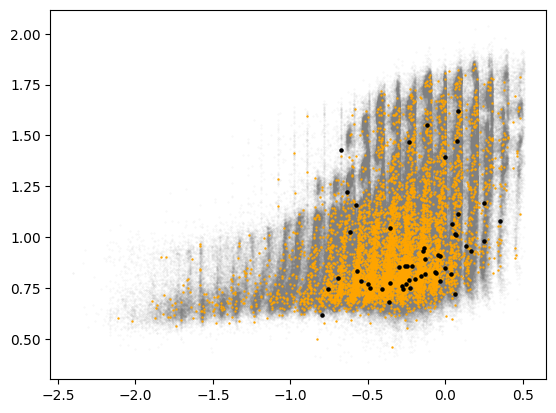

In [47]:
plt.scatter(tab['met50_StarHorse'], tab['BP-RP0_StarHorse'], s=0.1, alpha=0.1, color='gray')
plt.scatter(scr['met50_StarHorse'], scr['BP-RP0_StarHorse'], s=0.5, color='orange')
plt.scatter(best['met50_StarHorse'], best['BP-RP0_StarHorse'], s=5, color='k')

(8.1710639, 3.0539981000000003)

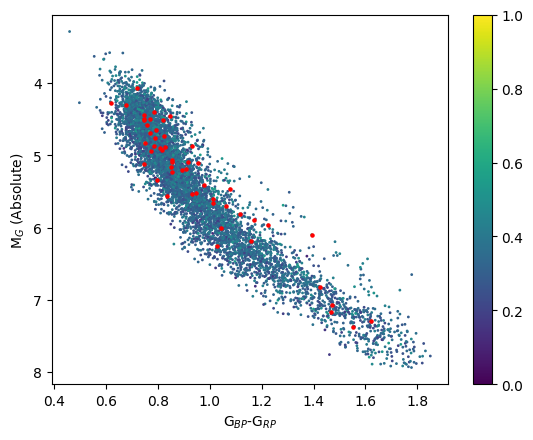

In [58]:
plt.scatter(scr['BP-RP0_StarHorse'], scr['GMAG0_StarHorse'], s=1, c=np.log(scr['lc_score']), 
           vmin=3, vmax=15)

plt.scatter(best['BP-RP0_StarHorse'], best['GMAG0_StarHorse'], s=5, color='red')

plt.ylabel("M$_{G}$ (Absolute)")
plt.xlabel("G$_{BP}$-G$_{RP}$")

plt.colorbar()
plt.ylim(plt.ylim()[::-1])

In [2]:
import pandas as pd

In [31]:
%%time
full_table = ens.object.compute() # full table compute

2024-04-08 12:47:15,861 - distributed.utils_perf - WARNING - full garbage collections took 69% CPU time recently (threshold: 10%)
2024-04-08 12:49:16,790 - distributed.utils_perf - WARNING - full garbage collections took 76% CPU time recently (threshold: 10%)
2024-04-08 12:49:43,354 - distributed.utils_perf - WARNING - full garbage collections took 77% CPU time recently (threshold: 10%)
2024-04-08 12:51:19,698 - distributed.utils_perf - WARNING - full garbage collections took 78% CPU time recently (threshold: 10%)
2024-04-08 12:52:52,571 - distributed.utils_perf - WARNING - full garbage collections took 78% CPU time recently (threshold: 10%)
2024-04-08 12:54:29,378 - distributed.utils_perf - WARNING - full garbage collections took 69% CPU time recently (threshold: 10%)
2024-04-08 12:56:34,434 - distributed.utils_perf - WARNING - full garbage collections took 78% CPU time recently (threshold: 10%)
2024-04-08 12:56:36,789 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-08 14:09:57,130 - distributed.utils_perf - WARNING - full garbage collections took 76% CPU time recently (threshold: 10%)
2024-04-08 14:11:04,173 - distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
2024-04-08 14:11:07,712 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2024-04-08 14:11:22,794 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2024-04-08 14:11:33,370 - distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
2024-04-08 14:12:36,821 - distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
2024-04-08 14:14:20,554 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2024-04-08 14:16:22,298 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-08 14:35:04,584 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:41282 -> tcp://127.0.0.1:44836
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert_stream_closed_error(self, e)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py"

2024-04-08 14:36:36,293 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2024-04-08 14:40:10,786 - distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
2024-04-08 14:41:31,300 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2024-04-08 14:42:26,378 - distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
2024-04-08 14:43:30,317 - distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
2024-04-08 14:43:48,201 - distributed.utils_perf - WARNING - full garbage collections took 80% CPU time recently (threshold: 10%)
2024-04-08 14:44:06,904 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33310'.
2024-04-08 14:44:06,906 - distributed.worker - WARNING - Scheduler was unaware of this work

2024-04-08 14:45:23,271 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44259
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2863, in get_data_from_worker
    response = await send_recv(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/core.py", line 1154, in send_re

2024-04-08 14:45:43,989 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2024-04-08 14:45:44,276 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:39635 -> tcp://127.0.0.1:44664
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert_stream_clos

2024-04-08 14:53:47,087 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40779'.
2024-04-08 14:53:47,127 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:40779 -> tcp://127.0.0.1:44664
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 297, in write
    raise StreamClosedError()
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 1782, in get_data
    compressed = await comm.write(msg, serializers=serializers)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 307, in write
    convert_stream_closed_error(self, e)
  File "/ep

2024-04-08 15:08:34,421 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2024-04-08 15:08:39,799 - distributed.utils_perf - WARNING - full garbage collections took 81% CPU time recently (threshold: 10%)
2024-04-08 15:08:40,103 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:36974 -> tcp://127.0.0.1:45317
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/epyc/users/atzanida/a

2024-04-08 15:10:43,693 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41110'.
2024-04-08 15:10:43,697 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-04-08 15:10:43,738 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name='gather_dep(tcp://127.0.0.1:44664, {...})' coro=<Worker.gather_dep() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-04-08 15:10:45,749 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-04-08 15:10:46,097 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 29.49 GiB -- W

2024-04-08 15:15:26,742 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 29.34 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:15:37,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 29.34 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:15:47,065 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 15:19:19,540 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 29.34 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:19:29,566 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 29.34 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:19:40,994 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 15:21:29,363 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 31.49 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:21:32,501 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 32.85 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:21:39,783 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 15:57:29,392 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 33.53 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:57:29,517 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 33.13 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:57:39,338 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 33.63 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:57:39,338 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.63 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 15:57:39,711 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 3

2024-04-08 16:00:40,490 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:00:50,491 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:01:00,590 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:04:41,992 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:04:51,992 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:05:02,090 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:08:43,391 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:08:53,490 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:09:03,591 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:12:44,991 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:12:54,991 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:13:05,089 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:16:46,390 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:16:56,390 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:17:06,490 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:20:47,491 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:20:57,590 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:21:07,591 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:24:49,091 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:24:59,189 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.54 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:25:09,190 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:28:20,491 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:28:30,589 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:28:40,590 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:32:21,491 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:32:31,589 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:32:41,589 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:36:22,790 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:36:32,889 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:36:42,890 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:40:24,390 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:40:34,489 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:40:44,490 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:44:25,689 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:44:35,689 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:44:45,690 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:48:27,089 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:48:37,089 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:48:47,089 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:52:28,189 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:52:38,289 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:52:48,389 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 16:56:29,589 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:56:39,687 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 16:56:49,688 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:00:30,788 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:00:40,789 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:00:50,888 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:04:32,088 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:04:42,187 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:04:52,188 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:08:33,687 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:08:43,787 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:08:53,788 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:12:35,387 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:12:45,387 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:12:55,387 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:16:36,487 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:16:46,487 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:16:56,488 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:20:37,886 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:20:47,887 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:20:57,888 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:24:39,186 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:24:49,285 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:24:59,287 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:28:40,487 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:28:50,586 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:29:00,586 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:32:41,987 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:32:51,987 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:33:02,087 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:36:43,287 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:36:53,386 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:37:03,487 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:40:44,486 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:40:54,486 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:41:04,586 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:44:45,686 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:44:55,786 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:45:05,885 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:48:46,986 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:48:57,086 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:49:07,185 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:52:48,384 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:52:58,385 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:53:08,385 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 17:56:49,685 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:56:59,784 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 17:57:09,786 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:00:50,785 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:01:00,785 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:01:10,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:04:52,283 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:05:02,284 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:05:12,285 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:08:53,184 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:09:03,285 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:09:13,383 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:12:54,583 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:13:04,683 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:13:14,683 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:16:55,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:17:05,984 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:17:16,086 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:20:56,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:21:06,984 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:21:17,083 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:24:58,883 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:25:08,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:25:18,984 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:29:00,484 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:29:10,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:29:20,682 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:33:02,182 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:33:12,183 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:33:22,282 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:37:03,283 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:37:13,382 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:37:23,383 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:41:04,583 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:41:14,682 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:41:24,783 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:45:06,082 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:45:16,183 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:45:26,282 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:49:07,981 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:49:17,981 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:49:27,982 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:53:09,382 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:53:19,485 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:53:29,581 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 18:57:11,081 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:57:21,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 18:57:31,181 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:01:12,382 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:01:22,482 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:01:32,581 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:05:13,982 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:05:24,081 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:05:34,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:09:15,380 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:09:25,381 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:09:35,481 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:13:16,680 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:13:26,780 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:13:36,781 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:17:18,381 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:17:28,381 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:17:38,381 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:21:19,580 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:21:29,679 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:21:39,680 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:25:20,880 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:25:30,979 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:25:40,980 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:29:22,380 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:29:32,479 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:29:42,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:33:23,380 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:33:33,480 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:33:43,579 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:37:25,080 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:37:35,179 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:37:45,280 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:41:26,479 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:41:36,479 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:41:46,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:45:27,579 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:45:37,678 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:45:47,679 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:49:28,779 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:49:38,779 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:49:48,878 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:53:29,979 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:53:40,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:53:50,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 19:57:31,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:57:41,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 19:57:51,179 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:01:32,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:01:42,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:01:52,777 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:05:34,378 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:05:44,478 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:05:54,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:09:35,877 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:09:45,878 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:09:55,977 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:13:37,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:13:47,184 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:13:57,277 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:17:38,577 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:17:48,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:17:58,776 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:21:40,278 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:21:50,377 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:22:00,377 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:25:41,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:25:51,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:26:01,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:29:42,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:29:53,076 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:30:03,077 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:33:44,075 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:33:54,076 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:34:04,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:37:45,675 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:37:55,776 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:38:05,876 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:41:47,376 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:41:57,476 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:42:07,576 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:45:48,775 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:45:58,776 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:46:08,876 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:49:50,274 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:50:00,274 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:50:10,375 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:53:51,375 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:54:01,475 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:54:11,574 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 20:57:53,174 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:58:03,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 20:58:13,274 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:01:54,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:02:04,673 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:02:14,775 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:05:55,973 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:06:05,974 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:06:16,073 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:09:57,474 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:10:07,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:10:17,574 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:13:58,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:14:08,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:14:18,774 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:18:00,174 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:18:10,272 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:18:20,273 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:22:01,474 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:22:11,572 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:22:21,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:26:02,773 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:26:12,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:26:22,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:30:04,172 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:30:14,173 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:30:24,273 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:34:05,773 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:34:15,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:34:25,873 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:38:06,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:38:16,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:38:26,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:42:07,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:42:17,971 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:42:28,072 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:46:08,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:46:18,873 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:46:28,971 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:50:10,172 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:50:20,172 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:50:30,272 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:54:11,271 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:54:21,372 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:54:31,470 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 21:58:12,471 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:58:22,571 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 21:58:32,670 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:02:14,171 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:02:24,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:02:34,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:06:15,370 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:06:25,469 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:06:35,471 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:10:16,671 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:10:26,770 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:10:36,771 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:14:17,969 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:14:27,969 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:14:38,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:18:19,470 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:18:29,470 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:18:39,569 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:22:20,770 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:22:30,770 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:22:40,869 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:26:21,969 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:26:32,068 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:26:42,068 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:30:23,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:30:33,370 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:30:43,468 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:34:24,968 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:34:34,969 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:34:45,070 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:38:26,368 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:38:36,469 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:38:46,569 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:42:27,969 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:42:37,969 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:42:48,068 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:46:29,269 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:46:39,369 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:46:49,467 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:50:30,667 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:50:40,669 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:50:50,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:54:31,868 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:54:41,968 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:54:52,068 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 22:58:33,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:58:43,367 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 22:58:53,368 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:02:34,567 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:02:44,666 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:02:54,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:06:35,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:06:45,866 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:06:55,967 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:10:37,366 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:10:47,466 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:10:57,467 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:14:38,667 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:14:48,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:14:58,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:18:40,367 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:18:50,368 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:19:00,468 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:22:41,566 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:22:51,567 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:23:01,666 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:26:43,165 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:26:53,166 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:27:03,265 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:30:44,365 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:30:54,466 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:31:04,466 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:34:45,666 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:34:55,766 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:35:05,865 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:38:47,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:38:57,166 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:39:07,266 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:42:48,865 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:42:58,966 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:43:09,065 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:46:50,265 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:47:00,364 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:47:10,364 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:50:51,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:51:01,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:51:11,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:54:53,064 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:55:03,065 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:55:13,163 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-08 23:58:54,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:59:04,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-08 23:59:14,564 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:02:55,764 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:03:05,864 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:03:15,964 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:06:57,264 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:07:07,363 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:07:17,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:10:58,763 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:11:08,764 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:11:18,764 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:15:00,162 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:15:10,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:15:20,263 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:19:01,463 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:19:11,563 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:19:21,662 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:23:03,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:23:13,063 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:23:23,163 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:27:04,263 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:27:14,362 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:27:24,462 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:31:05,462 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:31:15,462 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:31:25,561 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:35:06,962 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:35:17,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:35:27,163 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:39:08,363 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:39:18,462 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:39:28,562 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:43:10,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:43:20,162 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:43:30,162 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:47:11,761 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:47:21,862 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:47:31,961 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:51:13,461 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:51:23,561 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:51:33,662 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:55:15,061 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:55:25,161 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:55:35,261 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 00:59:16,661 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:59:26,761 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 00:59:36,861 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:03:18,159 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:03:28,161 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:03:38,161 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:07:19,360 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:07:29,361 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:07:39,461 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:11:20,561 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:11:30,659 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:11:40,660 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:15:21,960 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:15:31,960 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:15:41,960 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:19:23,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:19:33,160 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:19:43,259 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:23:24,460 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:23:34,460 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:23:44,460 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:27:25,759 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:27:35,759 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:27:45,858 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:31:27,259 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:31:37,260 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:31:47,364 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:35:28,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:35:38,460 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:35:48,558 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:39:30,259 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:39:40,358 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:39:50,359 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:43:31,658 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:43:41,758 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:43:51,759 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:47:33,059 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:47:43,159 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:47:53,258 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:51:34,958 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:51:45,058 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:51:55,158 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:55:36,457 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:55:46,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:55:56,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 01:59:37,858 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:59:47,956 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 01:59:57,958 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:03:39,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:03:49,257 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:03:59,356 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:07:40,257 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:07:50,356 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:08:00,357 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:11:41,357 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:11:51,457 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:12:01,556 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:15:42,756 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:15:52,856 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:16:02,957 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:19:44,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:19:54,357 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:20:04,456 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:23:45,756 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:23:55,756 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:24:05,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:27:46,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:27:56,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:28:06,856 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:31:48,055 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:31:58,055 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:32:08,055 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:35:49,356 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:35:59,454 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:36:09,456 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:39:50,755 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:40:00,854 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:40:10,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:43:52,255 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:44:02,354 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:44:12,354 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:47:53,755 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:48:03,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:48:13,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:51:54,955 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:52:05,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:52:15,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:55:56,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:56:06,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 02:56:16,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 02:59:57,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:00:07,454 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:00:17,553 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:03:58,754 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:04:08,853 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:04:18,853 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:08:00,454 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:08:10,454 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:08:20,454 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:12:02,052 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:12:12,153 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:12:22,153 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:16:03,353 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:16:13,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:16:23,553 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:20:04,653 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:20:14,752 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:20:24,753 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:24:06,053 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:24:16,053 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:24:26,153 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:28:07,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:28:17,352 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:28:27,352 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:32:08,752 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:32:18,852 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:32:28,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:36:10,152 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:36:20,252 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:36:30,352 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:40:11,552 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:40:21,652 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:40:31,750 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:44:12,850 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:44:22,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:44:32,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:48:14,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:48:24,450 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:48:34,451 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:52:15,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:52:25,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:52:35,750 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 03:56:16,751 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:56:26,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 03:56:36,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:00:17,850 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:00:27,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:00:37,950 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:04:19,249 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:04:29,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:04:39,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:08:20,550 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:08:30,551 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:08:40,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:12:21,950 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:12:32,049 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:12:42,050 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:16:23,350 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:16:33,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:16:43,449 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:20:24,848 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:20:34,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:20:44,950 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:24:26,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:24:36,449 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:24:46,449 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:28:27,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:28:37,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:28:48,049 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:32:29,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:32:39,749 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:32:49,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:36:31,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:36:41,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:36:51,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:40:32,947 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:40:42,948 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:40:52,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:44:34,149 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:44:44,247 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:44:54,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:48:35,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:48:45,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:48:55,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:52:36,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:52:46,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:52:56,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 04:56:38,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:56:48,047 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 04:56:58,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:00:39,546 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:00:49,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:00:59,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:04:41,047 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:04:51,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:05:01,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:08:42,647 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:08:52,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:09:02,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:12:44,047 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:12:54,146 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:13:04,246 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:16:45,446 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:16:55,546 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:17:05,647 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:20:47,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:20:57,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:21:07,245 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:24:48,346 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:24:58,445 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:25:08,446 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:28:49,346 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:28:59,446 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:29:09,546 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:32:51,145 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:33:01,145 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:33:11,244 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:36:52,645 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:37:02,645 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:37:12,745 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:40:53,745 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:41:03,745 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:41:13,845 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:44:55,044 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:45:05,145 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:45:15,244 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:48:56,844 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:49:06,944 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:49:17,044 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:52:58,344 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:53:08,345 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:53:18,443 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 05:56:59,743 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:57:09,844 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 05:57:19,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:01:01,344 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:01:11,443 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:01:21,543 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:05:02,842 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:05:12,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:05:22,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:09:04,344 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:09:14,444 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:09:24,445 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:13:05,743 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:13:15,743 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:13:25,743 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:17:07,043 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:17:17,142 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:17:27,143 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:21:08,543 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:21:18,642 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:21:28,642 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:25:09,841 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:25:19,843 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:25:29,942 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:29:11,142 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:29:21,142 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:29:31,242 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:33:12,342 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:33:22,441 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:33:32,541 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:37:13,641 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:37:23,641 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.72 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:37:33,740 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:41:15,041 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:41:25,140 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:41:35,141 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:45:16,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:45:26,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:45:36,340 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:49:17,541 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:49:27,640 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:49:37,740 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:53:19,042 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:53:29,142 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:53:39,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 06:57:20,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:57:30,340 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 06:57:40,340 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:01:21,440 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:01:31,440 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:01:41,540 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:05:23,240 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:05:33,339 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:05:43,339 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:09:24,640 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:09:34,738 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:09:44,739 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:13:26,040 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:13:36,040 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:13:46,138 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:17:27,439 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:17:37,539 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:17:47,540 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:21:28,839 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:21:38,939 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:21:49,038 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:25:30,538 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:25:40,638 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:25:50,639 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:29:31,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:29:41,838 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:29:51,939 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:33:33,239 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:33:43,338 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:33:53,339 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:37:35,037 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:37:45,038 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:37:55,038 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:41:36,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:41:46,738 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:41:56,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:45:37,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:45:47,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.73 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:45:57,838 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:49:38,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.71 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:49:48,838 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.71 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:49:58,937 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:53:40,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.71 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:53:50,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.71 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:54:00,437 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 07:57:41,536 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:57:51,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 07:58:01,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:01:42,937 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:01:53,035 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:02:03,035 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:05:44,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:05:54,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:06:04,436 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:09:45,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:09:55,835 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:10:05,835 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:13:46,935 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:13:56,935 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:14:07,035 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:17:47,936 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:17:58,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:18:08,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:21:49,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:21:59,136 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:22:09,236 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:25:50,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:26:00,536 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:26:10,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:29:51,635 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:30:01,734 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:30:11,735 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:33:52,940 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:34:03,035 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:34:13,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:37:54,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:38:04,335 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:38:14,335 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:41:55,733 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:42:05,735 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:42:15,834 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:45:57,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:46:07,133 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:46:17,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:49:58,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:50:08,332 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:50:18,334 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:53:59,733 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:54:09,733 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:54:19,833 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 08:58:01,133 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:58:11,133 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 08:58:21,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 09:02:02,333 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 09:02:12,432 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 09:02:22,433 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2024-04-09 09:06:03,933 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 09:06:14,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.70 GiB -- Worker memory limit: 41.91 GiB
2024-04-09 09:06:24,132 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

    @classmethod
KeyboardInterrupt: 
Exception ignored in atexit callback: <bound method finalize._exitfunc of <class 'weakref.finalize'>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/weakref.py", line 667, in _exitfunc
    f()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/diskutils.py", line 103, in _finalize
    workspace._purge_directory(dir_path)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/diskutils.py", line 228, in _purge_directory
    shutil.rmtree(dir_path, onerror=onerror)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/shutil.py", line 725, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/epyc/users/atzanida/

In [30]:
%%time
calc_.head(250, npartitions=25)

CPU times: user 2min 38s, sys: 14.3 s, total: 2min 52s
Wall time: 3min 29s


,Nphot,biweight_scale,frac_above_2_sigma,Ndips,rate,chi2dof,skew,kurtosis,mad,stetson_i,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,lc_score
_hipscat_index,,,,,,,,,,,,,,,,,,,,
12482248704,266.0,0.024350,0.022556,0.0,0.0,1.004714,-0.010657,2.038177,0.015356,7.684048,19.657562,0.759092,0.460740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116614234112,267.0,0.013218,0.026217,0.0,0.0,1.009678,-0.166459,0.700273,0.007980,34.753979,24.324205,0.764841,0.648049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751493447680,267.0,0.029874,0.026217,0.0,0.0,1.000762,0.299815,1.643119,0.019567,-5.506576,-10.058016,0.766275,0.566931,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1131799379968,267.0,0.013656,0.022472,0.0,0.0,1.010237,-0.466583,0.798873,0.008295,-1.530876,3.779188,0.779306,0.553092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1702816120832,267.0,0.014682,0.007491,0.0,0.0,1.012217,-0.781895,1.713557,0.009386,12.276953,14.363346,0.745565,0.498455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121534249172992,270.0,0.013829,0.029630,0.0,0.0,1.003574,-0.561682,3.306758,0.007973,-14.357451,-10.085254,0.706450,0.484659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171481615040512,268.0,0.014494,0.022388,0.0,0.0,1.001083,-0.272640,2.635552,0.009290,18.918163,13.820829,0.738790,0.390555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102827275845632,270.0,0.024209,0.018519,0.0,0.0,1.007710,-0.031022,3.598324,0.015493,31.517174,26.901697,0.737921,0.519599,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# previous working example as of April 4th 
%%time
calc_.head(1_000, npartitions=10)

CPU times: user 21 s, sys: 8.35 s, total: 29.4 s
Wall time: 33.2 s


,Nphot,biweight_scale,frac_above_2_sigma,Ndips,rate,chi2dof,skew,kurtosis,mad,stetson_i,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,lc_score
_hipscat_index,,,,,,,,,,,,,,,,,,,,
213961119105024,269.0,0.015609,0.018587,0.0,0.000000,1.003911,0.289721,0.743892,0.010347,95.148529,64.077812,0.794315,0.692493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572198062391296,268.0,0.014040,0.018657,0.0,0.000000,1.005126,-0.240236,0.024645,0.008913,23.233597,13.197321,0.779318,0.510219,NaN,NaN,NaN,NaN,NaN,NaN,NaN
471620435050496,217.0,0.013079,0.027650,0.0,0.000000,1.003753,0.198554,2.049891,0.008455,43.642849,35.884365,0.743563,0.602470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497394970001408,163.0,0.013869,0.000000,0.0,0.000000,1.012015,-4.228230,34.592444,0.008417,111.317398,54.295994,0.606832,0.501397,NaN,NaN,NaN,NaN,NaN,NaN,NaN
778339828629504,216.0,0.012959,0.032407,0.0,0.000000,1.000068,-0.114340,0.443450,0.008190,19.119101,20.018957,0.783205,0.582066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30574627545677824,247.0,0.012867,0.032389,0.0,0.000000,1.014547,0.613241,1.640722,0.007657,66.591125,40.524063,0.746860,0.775567,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30828687658057728,248.0,0.012120,0.016129,0.0,0.000000,1.004207,-0.329987,0.652126,0.007340,27.404694,21.355305,0.769521,0.558814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31221926558957568,250.0,0.014558,0.012000,1.0,0.000662,1.000003,0.657509,4.212327,0.009738,36.517708,24.180901,0.755607,0.422658,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
%%time
ens.object.join(calc_).update_ensemble()

# previous working example as of April 4th

In [ ]:
%%time
full_table = ens.object.compute() # full table compute
# previous working example as of April 4th

2024-04-05 17:17:42,886 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils_comm.py", line 434, in retry
    return await cor

2024-04-05 17:46:05,882 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 17:46:26,026 - distributed.worker.memory - WARNING - gc.collect() took 12.973s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2024-04-05 17:46:26,027 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 37.27 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 17:46:27,232 - distributed.worker.memory - WARNING - Worker is at 67% memory usage. Resuming worker. Process memory: 31.34 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 17:46:33,069 - distributed.worker.memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 41.94 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 17:46:35,516 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold:

2024-04-05 17:46:46,457 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:45341
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 230, in read
    buffer = await read_bytes_rw(stream, buffer_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py"

2024-04-05 17:48:39,548 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36932
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 230, in read
    buffer = await read_bytes_rw(stream, buffer_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py"

2024-04-05 17:49:47,740 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36932
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 546, in connect
    stream = await self.client.connect(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/tcpclient.py", line 279, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/asyncio/tasks.py", line 456, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_dem

2024-04-05 17:50:09,179 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 17:50:13,826 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 17:50:38,713 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 17:50:41,941 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 17:50:44,439 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 17:50:53,094 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 17:50:57,104 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 17:50:58,139 - distributed.utils_perf - WARNING - full garbage collections took

2024-04-05 18:01:15,391 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 36.59 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:01:21,485 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 36.45 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:01:25,663 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 37.30 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:01:27,553 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-04-05 18:01:33,177 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 34.69 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:01:33,471 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

2024-04-05 18:02:10,590 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39323
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 230, in read
    buffer = await read_bytes_rw(stream, buffer_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py"

2024-04-05 18:02:32,526 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33087
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 230, in read
    buffer = await read_bytes_rw(stream, buffer_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py"

2024-04-05 18:02:34,589 - distributed.diskutils - ERROR - Failed to remove '/epyc/ssd/users/atzanida/tmp/dask-scratch-space/worker-vd0xx98p/storage' (failed in <built-in function rmdir>): [Errno 2] No such file or directory: 'storage'
2024-04-05 18:02:34,589 - distributed.diskutils - ERROR - Failed to remove '/epyc/ssd/users/atzanida/tmp/dask-scratch-space/worker-vd0xx98p' (failed in <built-in function rmdir>): [Errno 2] No such file or directory: '/epyc/ssd/users/atzanida/tmp/dask-scratch-space/worker-vd0xx98p'
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.50s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
2024-04-05 18:02:38,288 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39323
Traceback (most rec

2024-04-05 18:02:47,260 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39323
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/core.py", line 342, in connect
    comm = await wait_for(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils.py", line 1940, in wait_for
    return await asyncio.wait_for(fut, timeout)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/asyncio/tasks.py", line 445, in wait_for
    return fut.result()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 559, in connect
    convert_stream_closed_error(self, e)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/li

2024-04-05 18:03:57,534 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 18:04:02,403 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 18:04:07,971 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 38.76 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:04:14,839 - distributed.worker.memory - WARNING - Worker is at 72% memory usage. Resuming worker. Process memory: 33.54 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:04:19,992 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 29.65 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:04:24,360 - distributed.uti

2024-04-05 18:06:00,794 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33083
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 227, in read
    frames_nosplit = await read_bytes_rw(stream, frames_nosplit_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distri

2024-04-05 18:06:28,534 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 18:06:31,844 - distributed.worker.memory - WARNING - gc.collect() took 16.270s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2024-04-05 18:06:37,116 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 18:06:46,002 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 18:06:51,836 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 38.37 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:06:57,972 - distributed.worker.memory - WARNING - Worker is at 67% memory usage. Resuming worker. Process memory: 31.54 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:07:16,032 - distribute

2024-04-05 18:08:42,279 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:34567
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 227, in read
    frames_nosplit = await read_bytes_rw(stream, frames_nosplit_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distri

2024-04-05 18:09:38,414 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-04-05 18:09:54,374 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 18:10:00,940 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-04-05 18:10:01,270 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 18:10:04,432 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 36.01 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:10:14,073 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 38.61 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:10:16,412 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 37.24 Gi

2024-04-05 18:11:06,898 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40864
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 230, in read
    buffer = await read_bytes_rw(stream, buffer_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py"

2024-04-05 18:11:16,014 - distributed.worker.memory - WARNING - Worker is at 72% memory usage. Resuming worker. Process memory: 33.68 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:11:34,388 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-04-05 18:11:35,484 - distributed.nanny - WARNING - Restarting worker
2024-04-05 18:11:49,107 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40864
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/core.py", line 342, in connect
    comm = await wait_for(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils.py", line 1940, in wait_for
    return await asyncio.wait_for(fut, timeout)


2024-04-05 18:11:59,891 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 41.84 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:12:01,285 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 18:12:08,258 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 18:12:20,855 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 36.88 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:12:27,976 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 18:12:33,784 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 18:12:36,584 - distributed.worker.memory - WARNING - Worker is at 91% memory usage. Pausing worker.  Process memory: 42.64 Gi

2024-04-05 18:13:21,084 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44539
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 227, in read
    frames_nosplit = await read_bytes_rw(stream, frames_nosplit_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distri

2024-04-05 18:13:34,956 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44539
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 297, in write
    raise StreamClosedError()
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2863, in get_data_from_worker
    response = await send_recv(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/core.py", line 1152, in send_recv
    await comm.write(msg, serial

2024-04-05 18:18:21,960 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 18:18:27,520 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 18:18:32,078 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 18:18:32,079 - distributed.worker.memory - WARNING - gc.collect() took 31.539s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2024-04-05 18:19:14,528 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2024-04-05 18:19:22,396 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 18:19:22,397 - distributed.worker.memory - WARNING - gc.collect() took 23.698s. This is usually a sign that s

2024-04-05 18:24:50,762 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 30.00 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:24:51,248 - distributed.worker.memory - WARNING - Worker is at 70% memory usage. Resuming worker. Process memory: 32.69 GiB -- Worker memory limit: 46.57 GiB
2024-04-05 18:24:53,720 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-04-05 18:25:02,205 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 18:25:02,206 - distributed.worker.memory - WARNING - gc.collect() took 23.753s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller t

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 230, in read
    buffer = await read_bytes_rw(stream, buffer_nbytes)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2059, in gather_dep
    response = await get_data_from_worker(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker.py", line 2863, in get_data_from_worker
    response = await send_recv(
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_

2024-04-05 18:27:06,821 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 18:27:06,831 - distributed.worker.memory - WARNING - gc.collect() took 21.455s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2024-04-05 18:27:27,841 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 18:28:11,744 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-04-05 18:28:18,511 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 18:28:39,897 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 18:28:42,155 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (thresh

In [27]:
client.close()

2024-04-25 05:20:12,813 - distributed.nanny - WARNING - Worker process still alive after 3.1999980163574224 seconds, killing
2024-04-25 05:20:12,816 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2024-04-25 05:20:12,819 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-04-25 05:20:12,826 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2024-04-25 05:20:12,828 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2024-04-25 05:20:12,830 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-04-25 05:20:12,833 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2024-04-25 05:20:12,842 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
20

TimeoutError: 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: closing,Using processes: True
Comm: tcp://127.0.0.1:34524,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 16 hours ago,Total memory: 0 B
